In [9]:
import os, math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lmfit.models import Model
from numpy import exp

%matplotlib inline
DEFAULT_RCPARAMS = {
#                              'font.family': 'serif',
#                              'font.serif': 'cmr10',
                              'font.size': 16,
                              'xtick.major.pad': 8,
                              'ytick.major.pad': 8,
                              'legend.fontsize': 'medium',
                              'xtick.labelsize': 'medium',
                              'ytick.labelsize': 'medium',
                              'axes.labelsize': 'medium',
                              'text.usetex': False,
                              'axes.unicode_minus': False,
#                               'savefig.dpi':150,
                              'legend.numpoints':1
                               }
mpl.rcParams.update(DEFAULT_RCPARAMS)

# mpl.rcParams['legend.numpoints'] = 1

/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


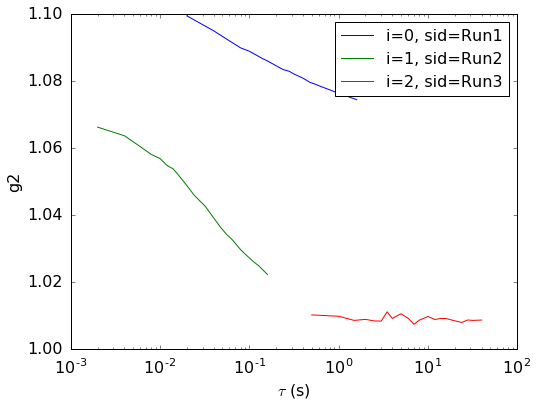

In [73]:
#input_dir = '/home/zhangz/2016_2_PEOXPCS/MultiData-SingleBox-Qr0135Qz022/results/'
input_dir = '/XF11ID/analysis/2016_3/zhangz/Results/'
measurement = 'PEO39k_AuNP20nm_25nM_Capillary_160C'
sub_dir = 'PEO39k-Dropcast/120C/'
run_list = ['Run1', 'Run2','Run3']
path_list = [input_dir + measurement + '_' + i + '/Average/' + 'uid='+ measurement + '_' + i +'@run--1--g2.csv' for i in run_list]
t = np.empty(0)
g2 = np.empty(0)

for filename in path_list:
     FileObject = open(filename, 'r')
#      header = FileObject.readline()
#      qrqz = header.split('"')[1]
     xcol , ycol = np.loadtxt(FileObject, delimiter=',', skiprows=1, usecols=(1,2), unpack=True)
     t = np.append(t, xcol)
     g2 = np.append(g2, ycol)

t_ = np.split(t, len(path_list))
g2_ = np.split(g2, len(path_list))

t_[2]=t_[2]*50
t=np.empty(0)
t=np.append(t, [t_[i] for i in range(3)])


if True: #Switch for plotting each segment
    
    fig, ax = plt.subplots(1, figsize=(8,6))
    for i in range(len(run_list)):
        ax.plot(t_[i], g2_[i], label='i=%s, sid='%i+run_list[i])

    ax.legend()
    ax.semilogx() 
    ax.set_xlabel(r'$\tau$ (s)')
    ax.set_xlim((0.001,100))
    ax.set_ylabel('g2')
    ax.set_ylim(ymin=1.0, ymax=1.1)
    
if False:
    fig.savefig(input_dir+sub_dir+'all-originals.png')

## Fudge factor

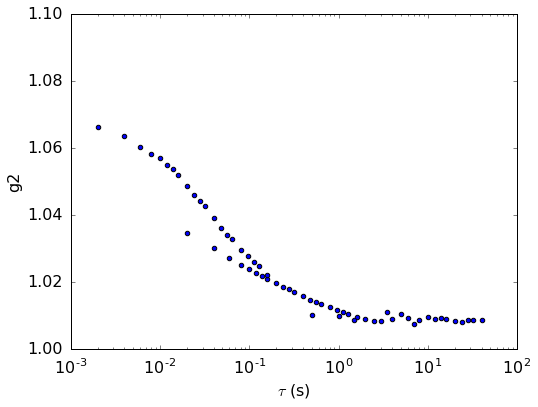

In [75]:
vshift = np.zeros((len(t_), len(t_[0]))) #fudge factor to shift the curve vertically

vshift[0,:] = -0.065

adjusted_g2_ = g2_ + vshift
adjusted_g2  = adjusted_g2_.ravel()

if True:
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.scatter(t_, adjusted_g2)
    
    ax.semilogx() 
    ax.set_xlabel(r'$\tau$ (s)')
    ax.set_xlim((0.001,100))
    ax.set_ylabel('g2')
    ax.set_ylim(ymin=1, ymax=1.1)

### Fit Exponential Decay

(1, 1.1)

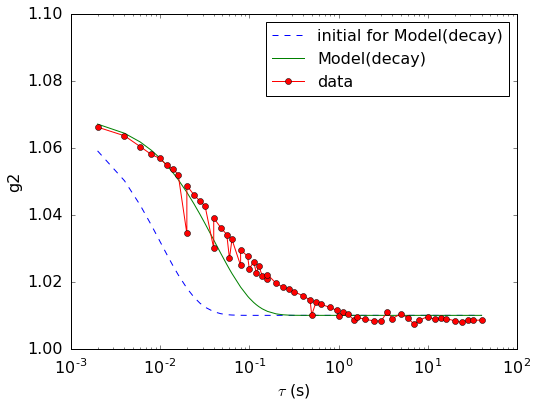

In [77]:
def decay(x, upper, lower, tau):
    return lower + (upper-lower) * exp(-x/tau)

mod = Model(decay)
mod.set_param_hint('upper', value=1.07, vary=False)
mod.set_param_hint('lower', value=1.01, vary=False)
mod.set_param_hint('tau', min=0.01, max=20)
# mod.set_param_hint('tau', value=0.21)

pars = mod.make_params()

sorted_indices = t.argsort()
sorted_adjusted_g2 = adjusted_g2 [sorted_indices]
sorted_t = t [sorted_indices]

# out = mod.fit(adjusted_g2, pars, method='nelder', x=t)
# out = mod.fit(sorted_adjusted_g2, pars, method='lbfgsb', x=sorted_t)
# out = mod.fit(adjusted_g2, pars, method='cg', x=t)
out = mod.fit(sorted_adjusted_g2, pars, method='leastsq', x=sorted_t)


fig, ax = plt.subplots(1, figsize=(8,6))
out.plot_fit(ax=ax, datafmt='o-')

# ax.scatter(t, adjusted_g2)

ax.semilogx() 
ax.set_xlabel(r'$\tau$ (s)')
ax.set_xlim((0.001,100))
ax.set_ylabel('g2')
ax.set_ylim(ymin=1, ymax=1.1)
# ax.set_title(sub_dir+' @ '+qrqz)

# ax.annotate(r'g2$_0$: %.3f'%out.values['upper'], xy=(100, out.values['upper']))
# ax.annotate(r'g2$_\infty$: %.3f'%out.values['lower'], xy=(100, out.values['lower']))
# ax.annotate(r'$\tau$: %.3f'%out.values['tau'], xy=(out.values['tau'], (out.values['lower']+out.values['upper'])/2))
# fig.tight_layout()

# if False:
#     fig.savefig(input_dir+sub_dir+'stitch-fit.png', bbox_inches='tight')

# print(out.fit_report())